# Take Home Chanllenge

In [132]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Part 1 ‐ Exploratory data analysis

In [107]:
login_data = pd.read_json('logins.json')
login_data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [73]:
login_data.set_index('login_time', inplace=True)

In [74]:
interval_login_counts = login_data.resample('15T').size()
interval_login_counts_df = pd.DataFrame(interval_login_counts)
interval_login_counts_df.columns = ['count']
interval_login_counts_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


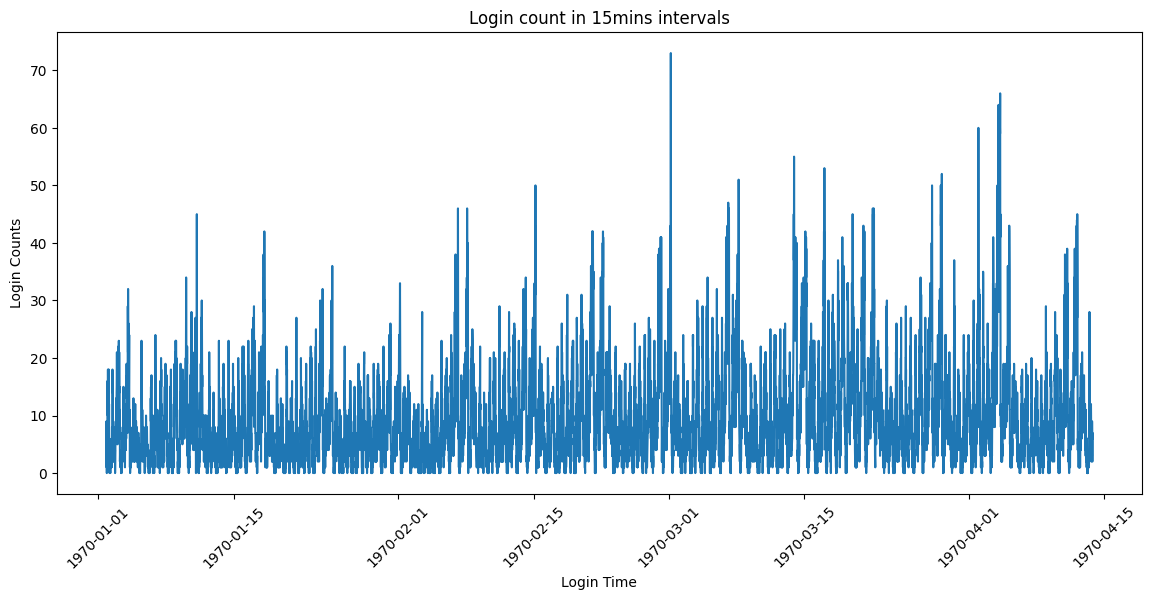

In [75]:
plt.figure(figsize=(14, 6))
plt.plot(interval_login_counts)
plt.title('Login count in 15mins intervals')
plt.xlabel('Login Time')
plt.ylabel('Login Counts')
plt.xticks(rotation=45)
plt.show()

In [84]:
interval_login_counts_df['datetime'] =  pd.to_datetime(interval_login_counts_df.index.to_pydatetime())
interval_login_counts_df['date'] = interval_login_counts_df['datetime'].dt.date
interval_login_counts_df['dayOfWeek'] = interval_login_counts_df['datetime'].dt.day_name()
interval_login_counts_df['hour'] = interval_login_counts_df['datetime'].dt.hour
interval_login_counts_df['time'] = interval_login_counts_df['datetime'].dt.time
interval_login_counts_df.head()

,count,datetime,date,dayOfWeek,hour,time
login_time,,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,1970-01-01,Thursday,20,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,1970-01-01,Thursday,20,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,1970-01-01,Thursday,20,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,1970-01-01,Thursday,20,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,1970-01-01,Thursday,21,21:00:00


In [100]:
daily_cycle = interval_login_counts_df.groupby(['dayOfWeek', 'time'])['count'].mean().unstack(level=0)
daily_cycle.head()

dayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,
00:00:00,15.800000,8.400000,19.800000,17.333333,15.285714,10.500000,11.285714
00:15:00,17.533333,9.333333,21.933333,18.266667,15.142857,10.785714,12.714286
00:30:00,15.466667,9.600000,20.866667,19.800000,14.428571,11.428571,12.642857
00:45:00,16.200000,8.066667,21.000000,19.466667,13.428571,10.642857,12.428571
01:00:00,17.266667,7.266667,23.800000,18.600000,14.285714,10.285714,14.357143


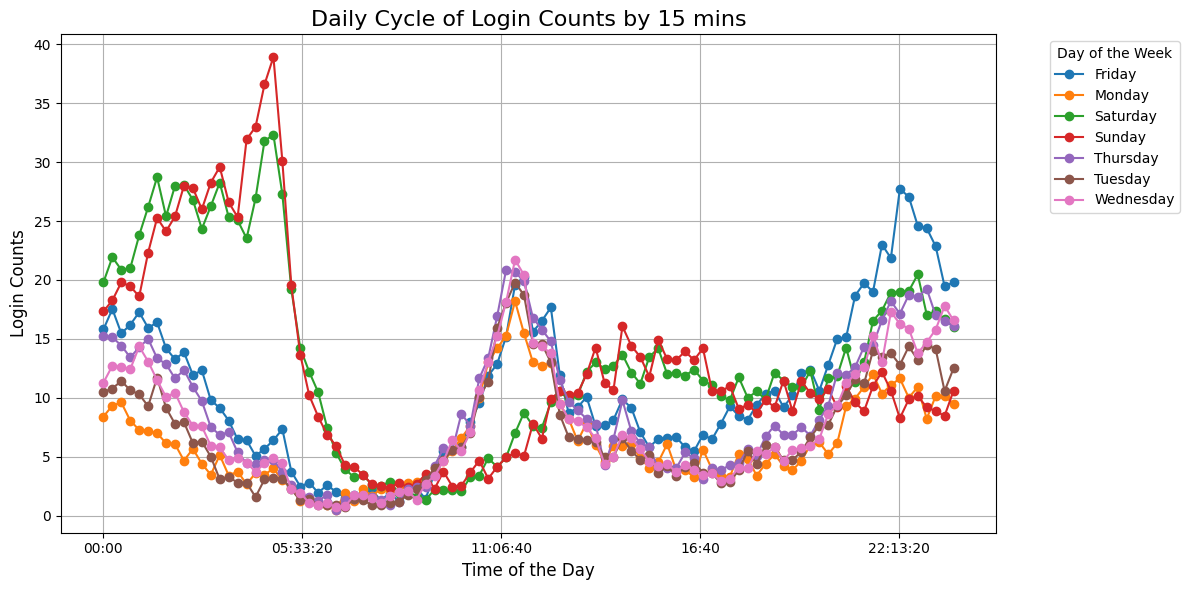

In [106]:
daily_cycle.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Daily Cycle of Login Counts by 15 mins', fontsize=16)
plt.xlabel('Time of the Day', fontsize=12)
plt.ylabel('Login Counts', fontsize=12)
plt.grid(True)
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

The login patterns show distinct differences between weekdays and weekends.

**Weekdays:**
We observe two major spikes in login activity. The first spike occurs around noon, suggesting users are active during the midday, possibly around lunch breaks.
The second noticeable increase in activity happens around 11 PM, likely indicating users logging in during the late evening hours.
After this late evening peak, login activity gradually decreases through the night and early morning.

**Weekends:**
The login pattern differs significantly on weekends. Login activity remains high through the late night, peaking in the early morning between midnight and 5 AM, indicating that users are more active during late-night hours on weekends.
After 5 AM, there is a sharp decline in logins, suggesting reduced activity in the early morning.
However, logins gradually increase again around noon, though the midday spike is less pronounced compared to weekdays.

## Part 2 ‐ Experiment and metrics design

#### 1) Key Measure of Success
Key Metric: Percentage of Drivers Serving Both Cities

This metric directly measures whether toll reimbursement encourages drivers to operate in both Gotham and Metropolis. It is a clear and straightforward indicator of the experiment’s success in breaking down barriers between the cities.

#### 2) Practical Experiment Design

##### a) Implementation of the Experiment:
- Control Group: Drivers continue paying tolls without reimbursement.
- Experimental Group: Drivers receive toll reimbursements for crossing the toll bridge.
- Data Collection: Track driver behavior over several weeks, focusing on the percentage of drivers serving both cities, trip frequency, earnings, and customer wait times.
- Randomization: Randomly assign drivers to groups to ensure fair comparison.
- Baseline: Collect pre-experiment data to compare results.

##### b) Statistical Tests:
- Chi-Square Test: Compare the proportion of drivers serving both cities between the experimental and control groups.
- T-Test or Mann-Whitney U Test: Compare driver earnings and number of cross-city trips between groups.
- Two-Way ANOVA: Analyze interactions between toll reimbursement and time of day/day of the week on cross-city trips.

##### c) Interpreting Results and Recommendations:
- If the experiment succeeds: Recommend continuing toll reimbursement to increase driver flexibility and improve service.
- If partially successful: Suggest additional incentives or easing other barriers.
- If the experiment fails: Recommend exploring other factors influencing driver behavior, such as convenience or familiarity with cities.

## Part 3 ‐ Predictive modeling

#### Shared functions

In [47]:
def plot_retain_by_category(categoryStr):
    retainedByCategory = data.groupby([categoryStr, 'retained']).size().unstack()
    retentionRate = retainedByCategory[True] / (retainedByCategory[False] + retainedByCategory[True]) * 100
    retainedByCategory.index = retainedByCategory.index.astype(str)
    
    if 'day_of_week' in categoryStr:
        custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    else:
        # Use the natural order of the category (unique values in the column)
        custom_order = retainedByCategory.index.tolist()
    
    fig, ax1 = plt.subplots(figsize=(8, 4))

    retainedByCategory.loc[custom_order].plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(categoryStr)
    ax1.set_ylabel('Number of Users')
    ax1.set_title(f"Retention by {categoryStr}")
    plt.xticks(rotation=45)
    
    for index, row in retainedByCategory.loc[custom_order].iterrows():
        retained_count = row[True]
        unretained_count = row[False]
        total = retained_count + unretained_count
        
        # Get the positions of the bars
        pos = custom_order.index(index)  # Get the index position of the category in custom order
        
        # Annotate unretained count
        ax1.text(pos, unretained_count / 2, f'{int(unretained_count)}', ha='center', va='center', color='white', fontsize=10)
        
        # Annotate retained count
        ax1.text(pos, unretained_count + retained_count / 2, f'{int(retained_count)}', ha='center', va='center', color='white', fontsize=10)
        
        # Annotate total count above the bar
        ax1.text(pos, total, f'Total: {int(total)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2 = ax1.twinx()
    ax2.plot(retentionRate.index, retentionRate.values, color='red', marker='o', label='Retention Rate')
    ax2.set_ylabel('Retention Rate (%)')
    ax2.legend(loc='upper right')
               
    plt.show()

In [4]:
def chiSquaredTest(categoryStr):
    contingency_table = pd.crosstab(data[categoryStr], data['retained'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-Squared Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Frequencies:\n{expected}")

    # Interpretation
    if p < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference in retention rates across {categoryStr}.")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in retention rates across {categoryStr}.")


### Data Wrangling

In [25]:
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Handle missing values

In [27]:
data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [28]:
data[data.isnull().any(axis=1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0


In [29]:
data.avg_rating_of_driver.unique(), data.avg_rating_by_driver.unique()

(array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
        3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
        2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2]),
 array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
        3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
        1.5, 2.7]))

Users with only a few trips tend to have incomplete rating data (both in terms of providing ratings and receiving them). Because ratings can vary significantly, using the mean or median to fill in missing values could misrepresent actual user behavior. Instead, since ratings are on a scale from 1 to 5, a value of 0 will be used to indicate the absence of rating data, clearly distinguishing users who haven't been rated from those who have.

In [30]:
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(0)
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(0)

For missing phone numbers, to avoid misrepresenting the actual user profile, the value will be filled with the string "Unknown."

In [31]:
data.phone = data.phone.fillna("Unknown")

In [32]:
data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

#### Drop duplicates

In [33]:
data[data.duplicated(keep=False)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
332,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
5958,Winterfell,1,2014-01-18,0.0,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
7836,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
10624,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
14990,Winterfell,1,2014-01-18,0.0,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
26709,Winterfell,1,2014-01-01,0.0,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0


In [34]:
data = data.drop_duplicates()
data[data.duplicated(keep=False)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


#### Correct data type

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49992 non-null  object 
 1   trips_in_first_30_days  49992 non-null  int64  
 2   signup_date             49992 non-null  object 
 3   avg_rating_of_driver    49992 non-null  float64
 4   avg_surge               49992 non-null  float64
 5   last_trip_date          49992 non-null  object 
 6   phone                   49992 non-null  object 
 7   surge_pct               49992 non-null  float64
 8   ultimate_black_user     49992 non-null  bool   
 9   weekday_pct             49992 non-null  float64
 10  avg_dist                49992 non-null  float64
 11  avg_rating_by_driver    49992 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [36]:
data.city = data.city.astype('category')
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.phone = data.phone.astype('string')
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  category      
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  datetime64[ns]
 6   phone                   49992 non-null  string        
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  bool          
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
dtypes: bool(1), category(1), datetime64[ns](2), float64

### EDA

In [37]:
# Given all the users signed up on January, will define as retained user if last trip is after 2014-06-01.
data['retained'] = data['last_trip_date'] >= pd.Timestamp(2014, 6, 1)
data['signup_day_of_week'] = data.signup_date.dt.day_name()
data['last_trip_day_of_week'] = data.last_trip_date.dt.day_name()
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day_of_week,last_trip_day_of_week
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,Saturday,Tuesday
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,Wednesday,Monday
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,Monday,Tuesday
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,Friday,Sunday
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,Monday,Saturday


#### Variable distributions

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


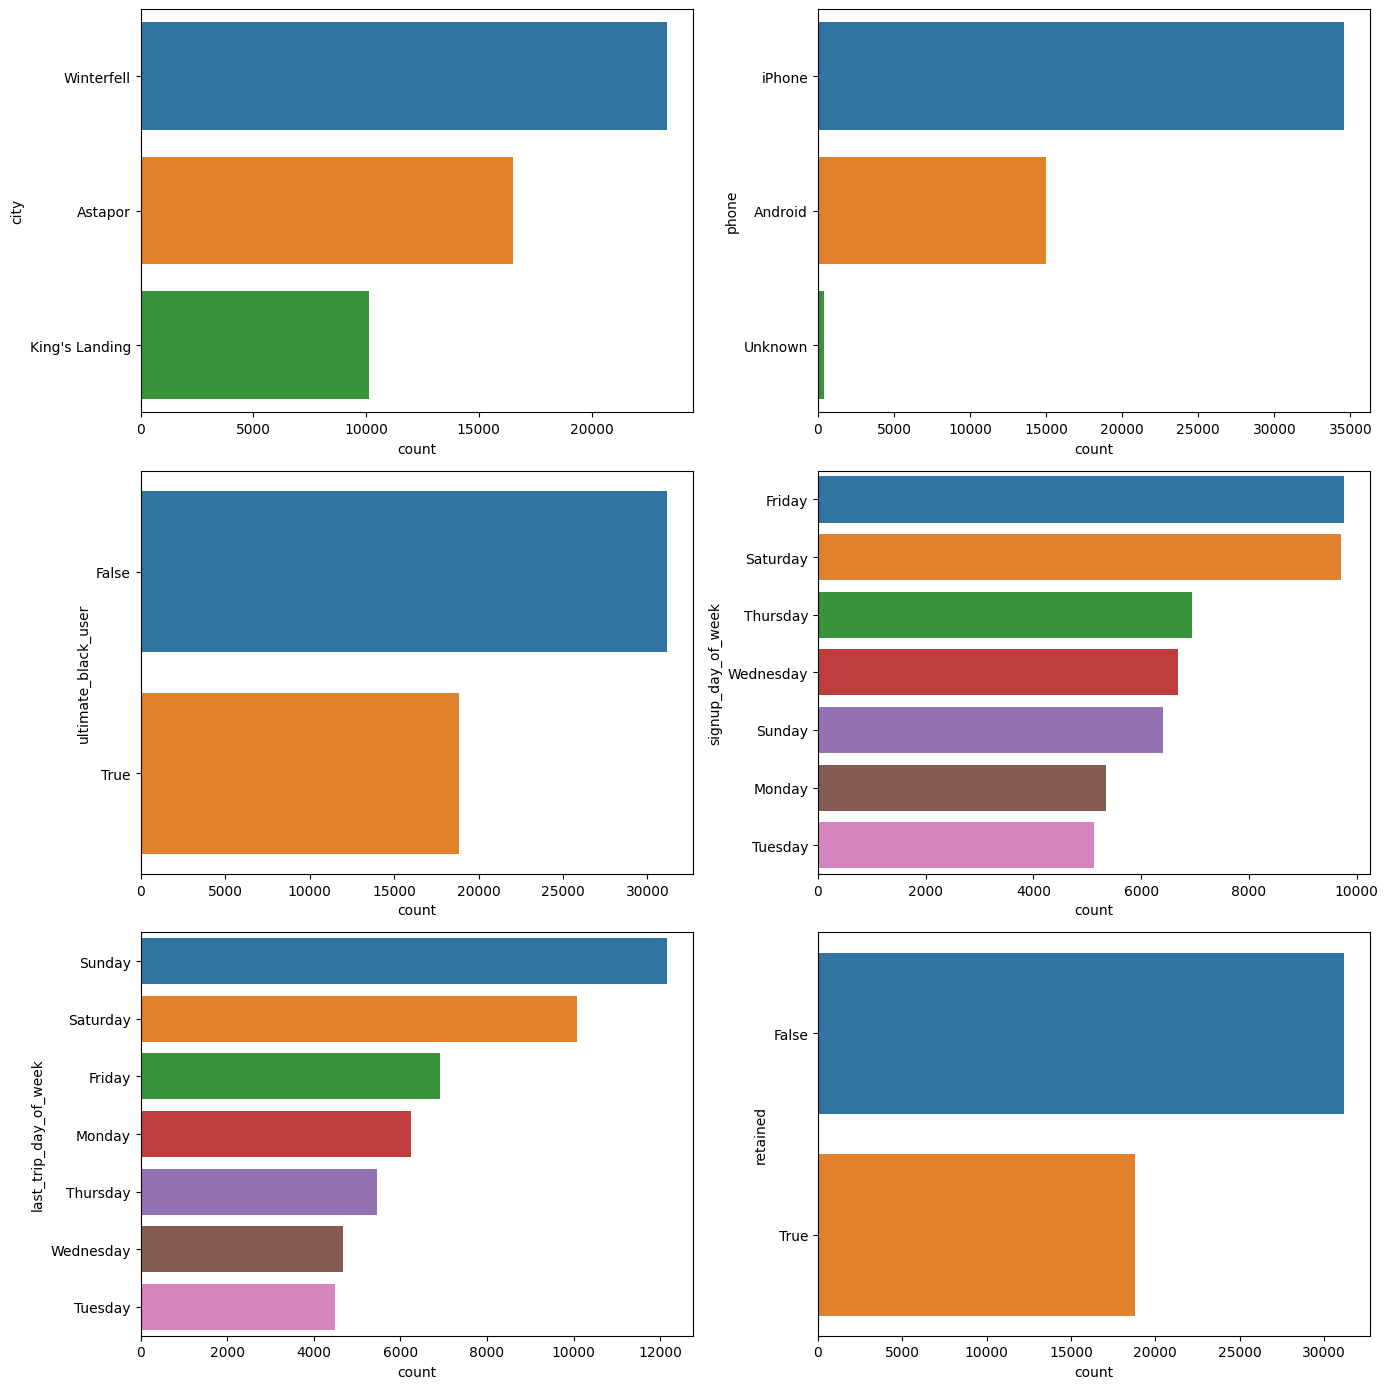

In [39]:
categorical_cols = ['city', 'phone', 'ultimate_black_user', 'signup_day_of_week', 'last_trip_day_of_week', 'retained']

fig, axes = plt.subplots(3,2, figsize=(14,14))

for idx, col in enumerate(categorical_cols):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.countplot(data=data, y=col,  ax=axes[row_idx, col_idx], order = data[col].value_counts().index)


plt.tight_layout()
plt.show()

In [40]:
num_cols = data.select_dtypes(include=['int64', 'float64'])

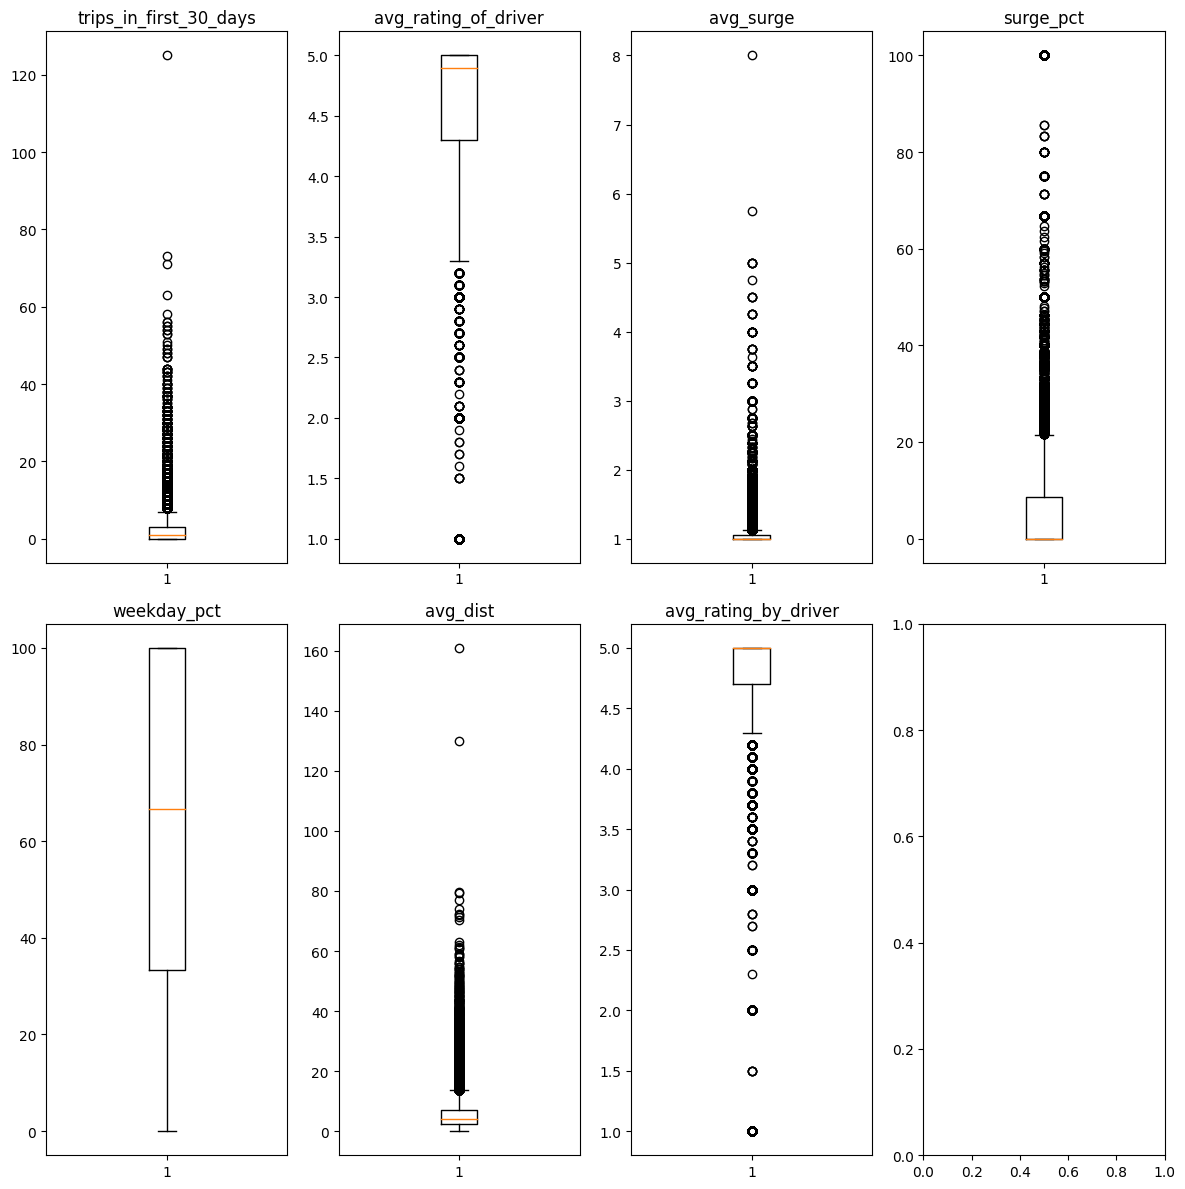

In [41]:
fig, axes = plt.subplots(2,4, figsize=(12,12))

for idx, col in enumerate(num_cols):
    row_idx = idx // 4
    col_idx = idx % 4
    if (col == 'avg_rating_of_driver') or (col == 'avg_rating_by_driver'):
        axes[row_idx, col_idx].boxplot(data[data[col] > 0][col])
    else:
        axes[row_idx, col_idx].boxplot(data[col])
    axes[row_idx, col_idx].set_title(col)


plt.tight_layout()
plt.show()

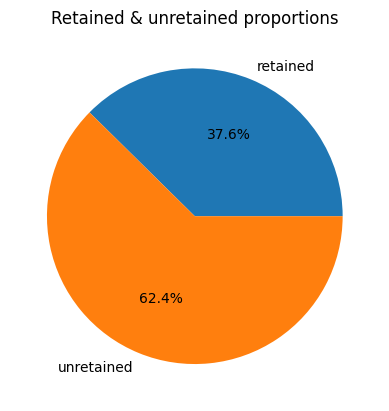

In [43]:
plt.pie([data.retained.sum(), len(data) - data.retained.sum()], labels=['retained', 'unretained'], autopct='%1.1f%%')
plt.title('Retained & unretained proportions')
plt.show()

#### Retention by category

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_25225/2446314278.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retainedByCategory = data.groupby([categoryStr, 'retained']).size().unstack()


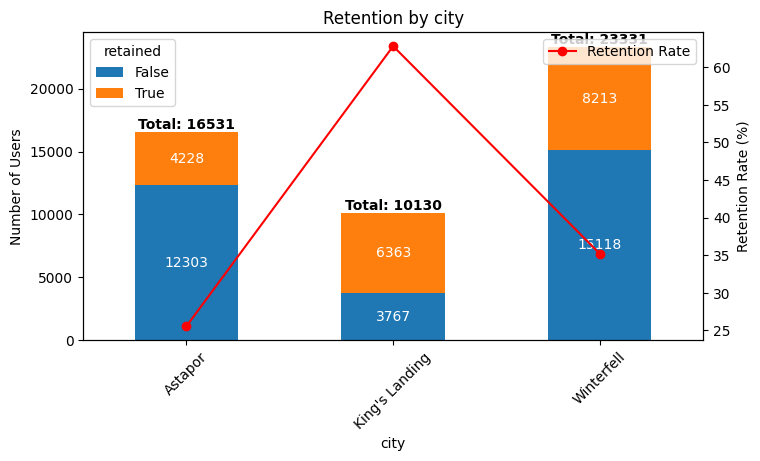

In [48]:
# Retain by city
plot_retain_by_category('city')

In [46]:
chiSquaredTest('city')

Chi-Squared Statistic: 3819.9615245128007
P-Value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[10313.02664426  6217.97335574]
 [ 6319.69995199  3810.30004801]
 [14555.27340374  8775.72659626]]
Reject the null hypothesis: There is a significant difference in retention rates across city.


King's Landing stands out with the highest retention rate despite having the smallest user base, indicating strong user engagement. In contrast, Winterfell has the largest user base and the highest number of retained users, but its retention rate is relatively low, suggesting potential challenges in retaining such a large user population. Astapor has both a low retention rate and a moderate user base, highlighting an opportunity to improve user retention strategies.

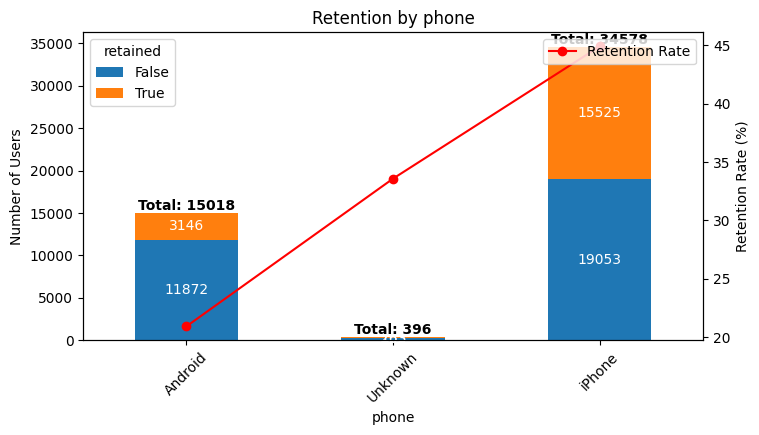

In [49]:
# Retain by phone
plot_retain_by_category('phone')

In [50]:
chiSquaredTest('phone')

Chi-Squared Statistic: 2562.23163673736
P-Value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[ 9369.12674028  5648.87325972]
 [  247.04848776   148.95151224]
 [21571.82477196 13006.17522804]]
Reject the null hypothesis: There is a significant difference in retention rates across phone.


iPhone users have a 25% higher retention rate compared to Android users. Additionally, the larger iPhone user base results in nearly five times more retained users than Android.

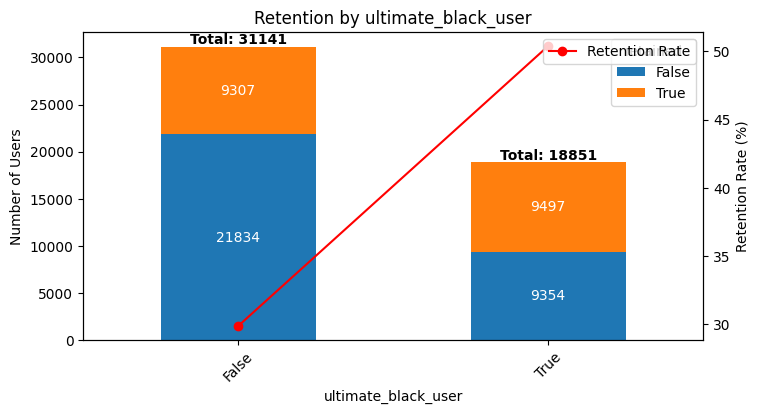

In [51]:
# Retain by ultimate black user
plot_retain_by_category('ultimate_black_user')

In [52]:
chiSquaredTest('ultimate_black_user')

Chi-Squared Statistic: 2100.609163972583
P-Value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[19427.61857897 11713.38142103]
 [11760.38142103  7090.61857897]]
Reject the null hypothesis: There is a significant difference in retention rates across ultimate_black_user.


Ultimate Black users have a 20% higher retention rate compared to non-Ultimate Black users. Despite non-Ultimate Black users having a larger overall user base, the number of retained users is still higher for Ultimate Black.

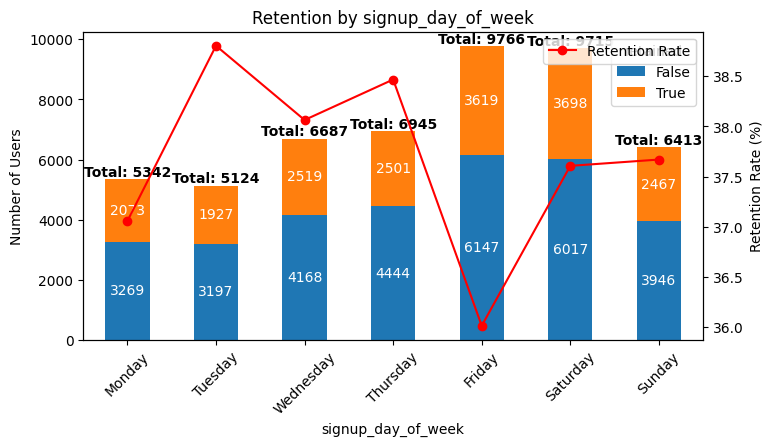

In [53]:
# Retain by signup day of week
plot_retain_by_category('signup_day_of_week')

In [54]:
chiSquaredTest('signup_day_of_week')

Chi-Squared Statistic: 14.970781289714456
P-Value: 0.020485192274638252
Degrees of Freedom: 6
Expected Frequencies:
[[6092.6149784  3673.3850216 ]
 [3332.65914546 2009.34085454]
 [6060.7981277  3654.2018723 ]
 [4000.81301008 2412.18698992]
 [4332.70643303 2612.29356697]
 [3196.65770523 1927.34229477]
 [4171.7506001  2515.2493999 ]]
Reject the null hypothesis: There is a significant difference in retention rates across signup_day_of_week.


The retention rate varies slightly across the week, ranging from 36% to 38%. Despite having the second-highest number of sign-ups, Friday shows the lowest retention rate, indicating that a higher volume of sign-ups does not necessarily lead to better retention. In contrast, Tuesday, Wednesday, and Thursday have fewer sign-ups but higher retention rates, suggesting that mid-week users are more likely to stay engaged.

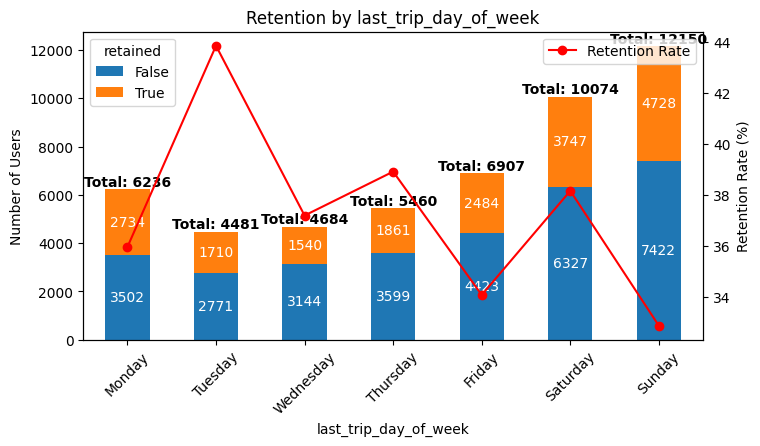

In [55]:
# Retain by last trip day of week, month
plot_retain_by_category('last_trip_day_of_week')

In [56]:
chiSquaredTest('last_trip_day_of_week')

Chi-Squared Statistic: 194.93769699866485
P-Value: 2.2668848000330495e-39
Degrees of Freedom: 6
Expected Frequencies:
[[4308.99975996 2598.00024004]
 [3890.38982237 2345.61017763]
 [6284.76380221 3789.23619779]
 [7579.89678349 4570.10321651]
 [3406.27460394 2053.72539606]
 [2795.51584253 1685.48415747]
 [2922.1593855  1761.8406145 ]]
Reject the null hypothesis: There is a significant difference in retention rates across last_trip_day_of_week.


Weekday users, especially those who took their last trip on Tuesday, show higher retention rates. However, the majority of last trips occur on weekends, especially on Saturday and Sunday, which have the lower retention rates. This pattern suggests that retaining users who become inactive on weekends could be a key area of focus.

#### Retention by numerical features

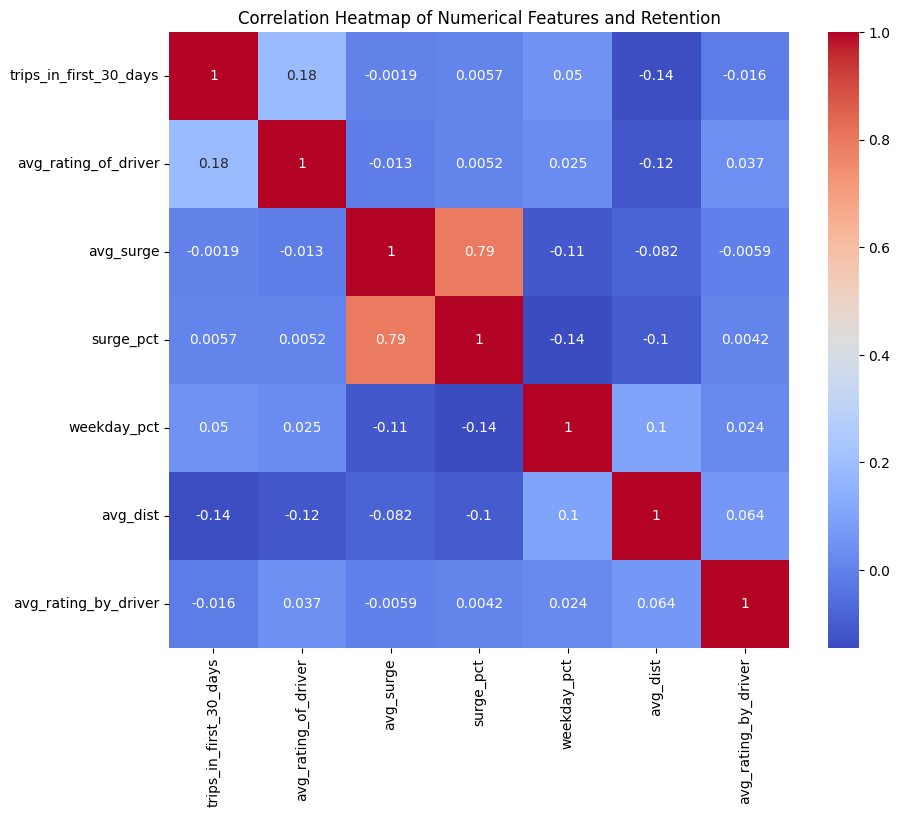

In [57]:
corr_matrix = num_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features and Retention')
plt.show()

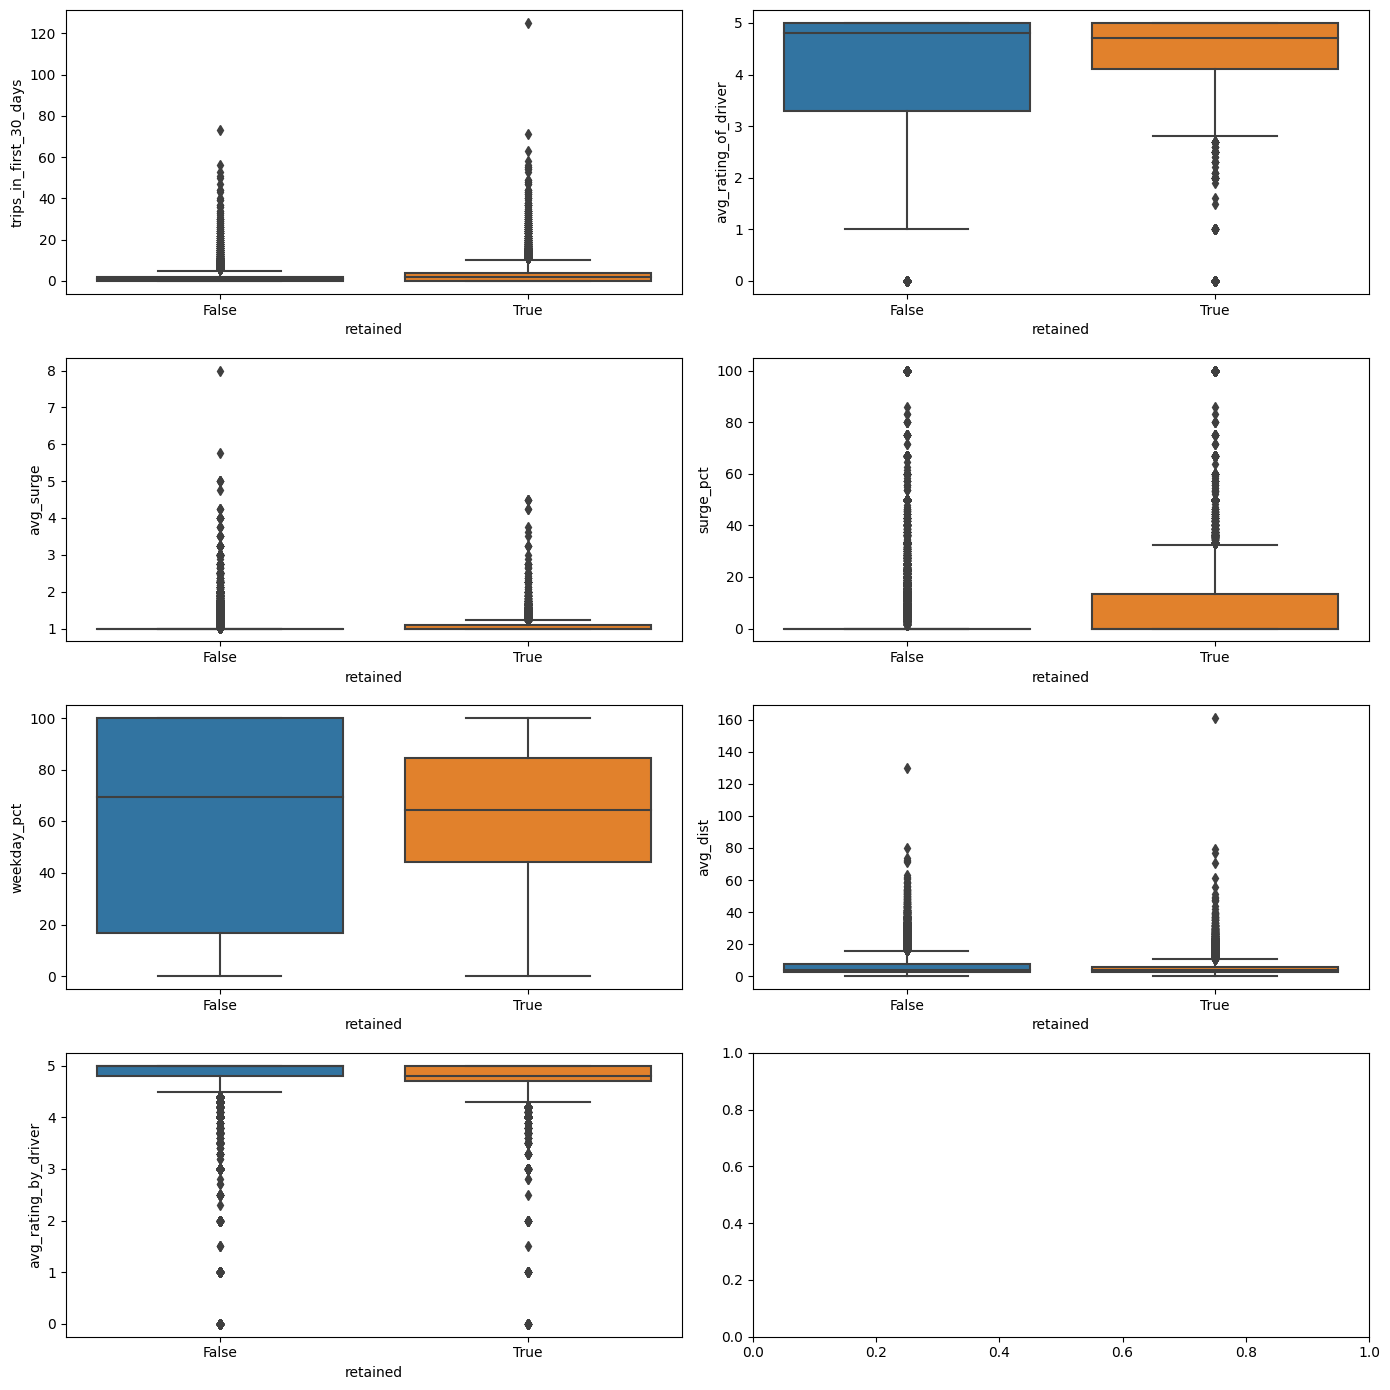

In [59]:
fig, axes = plt.subplots(4,2, figsize=(14,14))

for idx, col in enumerate(num_cols.columns):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.boxplot(x='retained', y=col, data=data, ax=axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


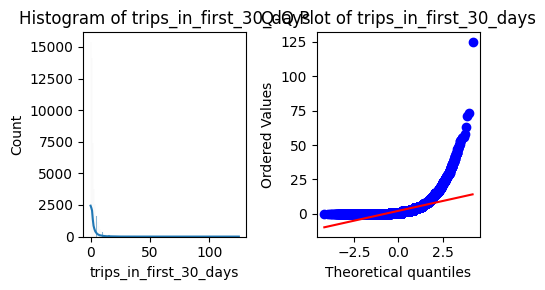

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


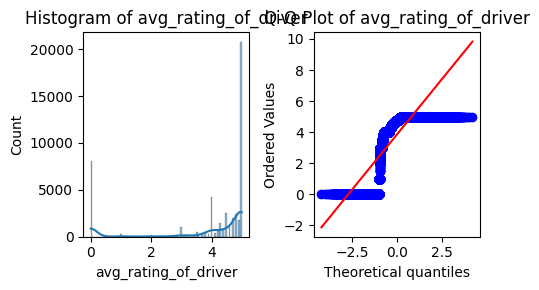

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


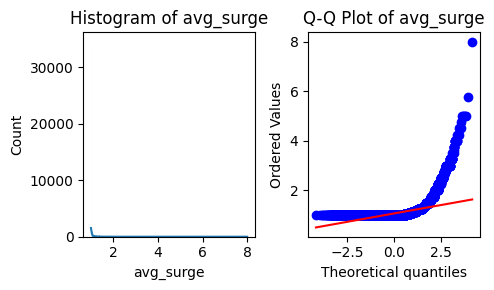

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


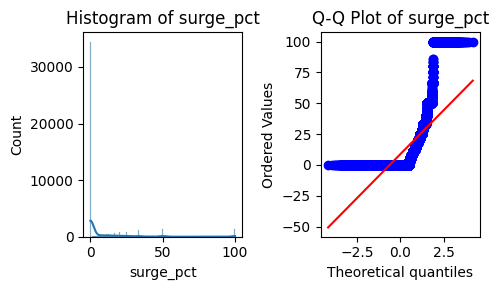

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


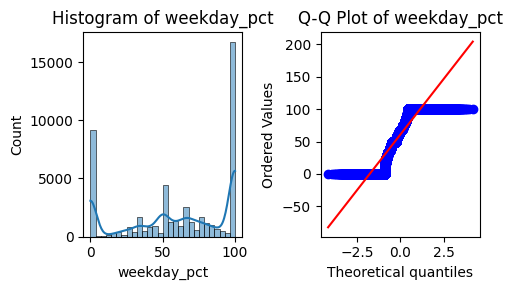

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


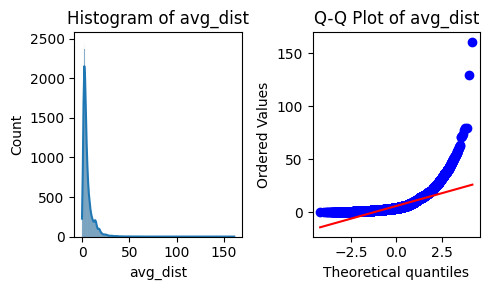

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


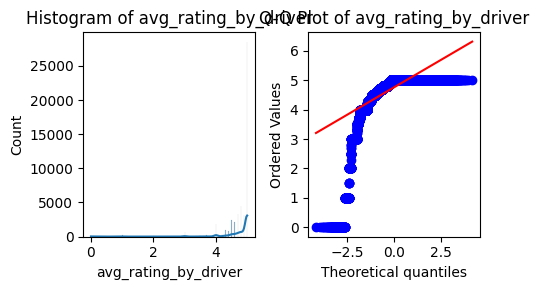

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in num_cols.columns:
    # Histogram
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')
    
    plt.tight_layout()
    plt.show()

In [61]:
# Run Mann-Whitney U Test because data not normaly distributed

for feature in num_cols.columns:
    retained = data[data['retained'] == True][feature]
    not_retained = data[data['retained'] == False][feature]

    u_stat, p_value = mannwhitneyu(retained, not_retained)
    print(f"{feature} - U-statistic: {u_stat}, P-value: {p_value}")

trips_in_first_30_days - U-statistic: 351748840.0, P-value: 0.0
avg_rating_of_driver - U-statistic: 300343288.0, P-value: 2.1694839781084874e-06
avg_surge - U-statistic: 361274665.0, P-value: 0.0
surge_pct - U-statistic: 358868810.0, P-value: 0.0
weekday_pct - U-statistic: 275247957.5, P-value: 5.917662004774997e-32
avg_dist - U-statistic: 281107606.5, P-value: 8.823323917151204e-15
avg_rating_by_driver - U-statistic: 217428426.5, P-value: 0.0


All p-values are below 0.05, indicating statistically significant differences between retained and non-retained users for all numerical features tested.

### Modeling

In [113]:
def metrics_summary(y_test, y_pred, y_pred_prob):
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    if y_pred_prob is not None:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

#### Data pre-processingy_pred_prob

In [152]:
modeling_data = pd.get_dummies(data, columns=['city', 'phone', 'ultimate_black_user', 'signup_day_of_week', 'last_trip_day_of_week'], dtype='int')
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   trips_in_first_30_days           49992 non-null  int64         
 1   signup_date                      49992 non-null  datetime64[ns]
 2   avg_rating_of_driver             49992 non-null  float64       
 3   avg_surge                        49992 non-null  float64       
 4   last_trip_date                   49992 non-null  datetime64[ns]
 5   surge_pct                        49992 non-null  float64       
 6   weekday_pct                      49992 non-null  float64       
 7   avg_dist                         49992 non-null  float64       
 8   avg_rating_by_driver             49992 non-null  float64       
 9   retained                         49992 non-null  bool          
 10  city_Astapor                     49992 non-null  int64         

In [153]:
X = modeling_data.drop(['retained', 'signup_date', 'last_trip_date'], axis=1)
y = modeling_data['retained']

X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   trips_in_first_30_days           49992 non-null  int64  
 1   avg_rating_of_driver             49992 non-null  float64
 2   avg_surge                        49992 non-null  float64
 3   surge_pct                        49992 non-null  float64
 4   weekday_pct                      49992 non-null  float64
 5   avg_dist                         49992 non-null  float64
 6   avg_rating_by_driver             49992 non-null  float64
 7   city_Astapor                     49992 non-null  int64  
 8   city_King's Landing              49992 non-null  int64  
 9   city_Winterfell                  49992 non-null  int64  
 10  phone_Android                    49992 non-null  int64  
 11  phone_Unknown                    49992 non-null  int64  
 12  phone_iPhone           

(None, None)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [183]:
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply scaling to numerical columns
numerical_cols = [
    'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 
    'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'
]
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [156]:
X_train_scaled.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,...,signup_day_of_week_Thursday,signup_day_of_week_Tuesday,signup_day_of_week_Wednesday,last_trip_day_of_week_Friday,last_trip_day_of_week_Monday,last_trip_day_of_week_Saturday,last_trip_day_of_week_Sunday,last_trip_day_of_week_Thursday,last_trip_day_of_week_Tuesday,last_trip_day_of_week_Wednesday
5882,0.000,0.94,0.000,0.000,1.000,0.071260,1.00,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7472,0.016,0.80,0.000,0.000,1.000,0.088283,1.00,0,1,0,...,0,0,0,0,0,0,0,1,0,0
25824,0.040,0.92,0.015,0.111,0.333,0.029262,0.98,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5610,0.008,0.00,0.000,0.000,1.000,0.019322,1.00,1,0,0,...,0,0,0,0,0,1,0,0,0,0
35934,0.016,1.00,0.000,0.000,1.000,0.008760,1.00,1,0,0,...,0,1,0,0,0,0,0,0,0,1


#### Predictive Modeling

In [157]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

       False       0.74      0.85      0.79      7819
        True       0.67      0.50      0.57      4679

    accuracy                           0.72     12498
   macro avg       0.71      0.68      0.68     12498
weighted avg       0.71      0.72      0.71     12498



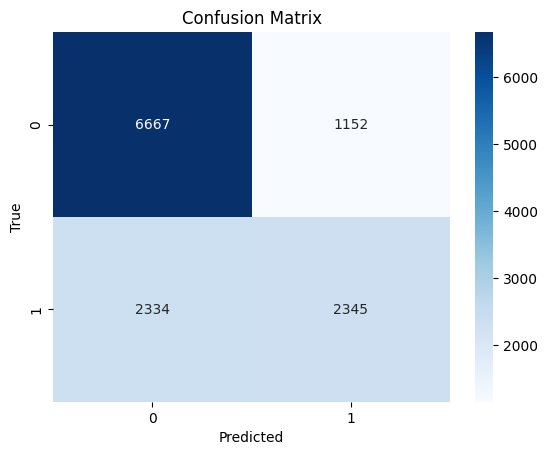

ROC-AUC Score: 0.7648


In [158]:
metrics_summary(y_test, y_pred, y_pred_prob)

In [159]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_pred_prob = rf.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

       False       0.80      0.84      0.82      7819
        True       0.71      0.65      0.68      4679

    accuracy                           0.77     12498
   macro avg       0.75      0.74      0.75     12498
weighted avg       0.77      0.77      0.77     12498



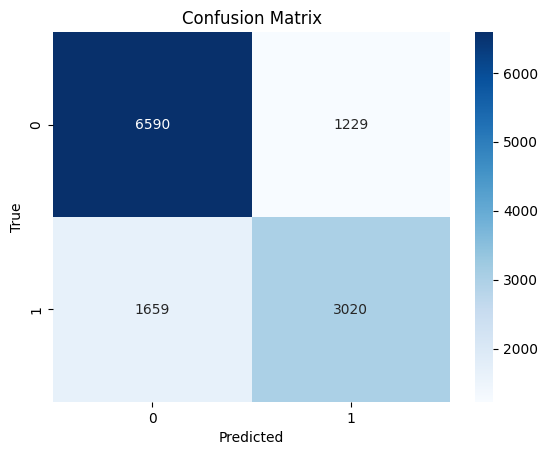

ROC-AUC Score: 0.8364


In [160]:
metrics_summary(y_test, y_pred, y_pred_prob)

In [161]:
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
y_pred_prob = gb.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

       False       0.81      0.86      0.83      7819
        True       0.74      0.66      0.70      4679

    accuracy                           0.78     12498
   macro avg       0.77      0.76      0.77     12498
weighted avg       0.78      0.78      0.78     12498



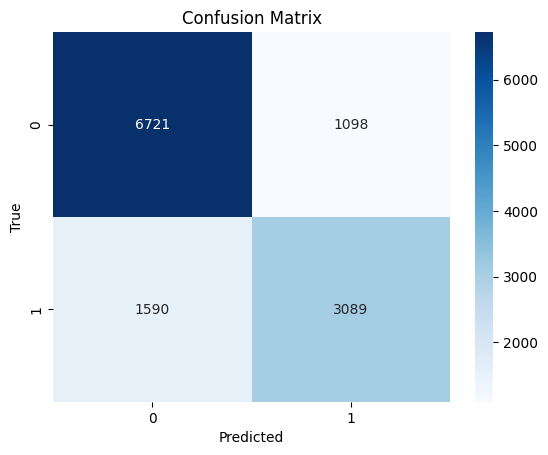

ROC-AUC Score: 0.8554


In [162]:
metrics_summary(y_test, y_pred, y_pred_prob)

In [163]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)

              precision    recall  f1-score   support

       False       0.77      0.84      0.80      7819
        True       0.68      0.58      0.63      4679

    accuracy                           0.74     12498
   macro avg       0.73      0.71      0.71     12498
weighted avg       0.74      0.74      0.74     12498



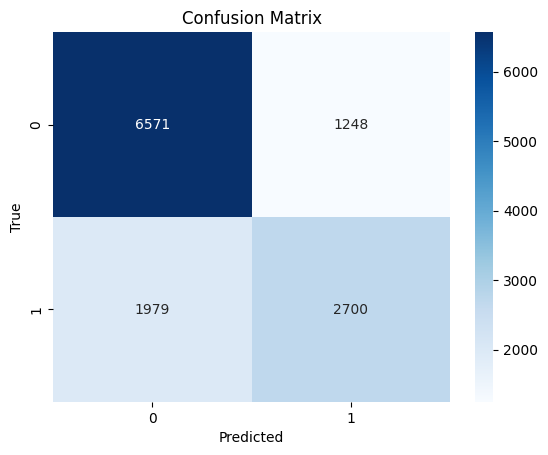

In [164]:
metrics_summary(y_test, y_pred, None)

In [165]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
y_pred_prob = nb.predict_proba(X_test_scaled)[:, 1]

              precision    recall  f1-score   support

       False       0.81      0.70      0.75      7819
        True       0.59      0.72      0.65      4679

    accuracy                           0.71     12498
   macro avg       0.70      0.71      0.70     12498
weighted avg       0.72      0.71      0.71     12498



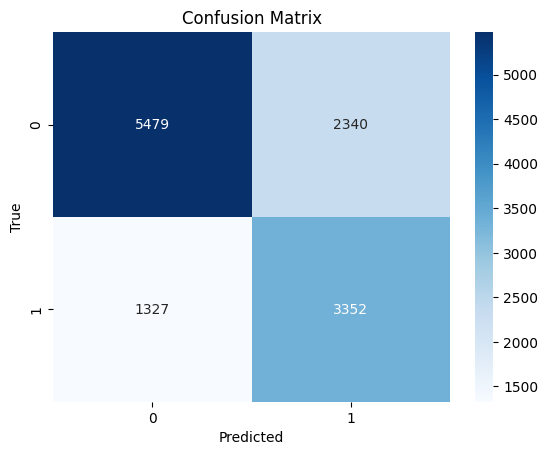

ROC-AUC Score: 0.7700


In [166]:
metrics_summary(y_test, y_pred, y_pred_prob)

Among all the models, the Gradient Boosting Classifier performed the best with a ROC-AUC score of 0.85 and an accuracy of 0.78. However, to better understand which factors are the strongest predictors of retention and provide actionable insights, Logistic Regression is more interpretable and offers coefficients that reveal how each feature impacts the probability of retention.

Best Parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC Score for Logistic Regression: 0.7656
              precision    recall  f1-score   support

       False       0.74      0.85      0.80      7819
        True       0.68      0.51      0.58      4679

    accuracy                           0.72     12498
   macro avg       0.71      0.68      0.69     12498
weighted avg       0.72      0.72      0.71     12498



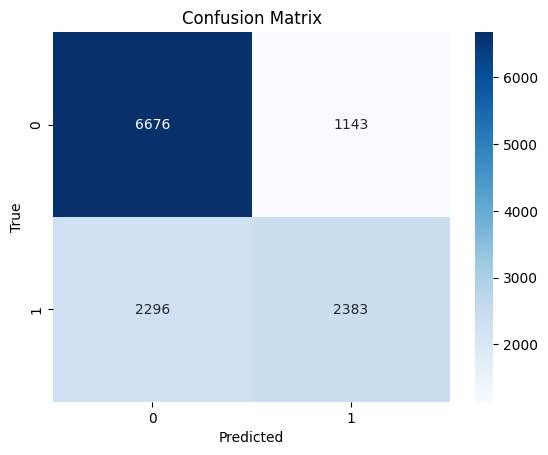

ROC-AUC Score: 0.7651


In [198]:
warnings.filterwarnings("ignore")
log_reg = LogisticRegression()
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],   
    'penalty': ['l1', 'l2'],        
    'solver': ['liblinear', 'saga'],
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Best Parameters for Logistic Regression:", grid_lr.best_params_)
print(f"Best ROC-AUC Score for Logistic Regression: {grid_lr.best_score_:.4f}")

y_pred_lr = grid_lr.predict(X_test_scaled)
y_pred_prob_lr = grid_lr.predict_proba(X_test_scaled)[:, 1]

metrics_summary(y_test, y_pred_lr, y_pred_prob_lr)

In [199]:
gb = GradientBoostingClassifier()
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 5, 7],                  
}

grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)

print("Best Parameters for Gradient Boosting:", grid_gb.best_params_)
print(f"Best ROC-AUC Score for Gradient Boosting: {grid_gb.best_score_:.4f}")

y_pred_gb = grid_gb.predict(X_test_scaled)
y_pred_prob_gb = grid_gb.predict_proba(X_test_scaled)[:, 1]

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5}
Best ROC-AUC Score for Gradient Boosting: 0.8577


              precision    recall  f1-score   support

       False       0.81      0.87      0.84      7819
        True       0.75      0.67      0.71      4679

    accuracy                           0.79     12498
   macro avg       0.78      0.77      0.77     12498
weighted avg       0.79      0.79      0.79     12498



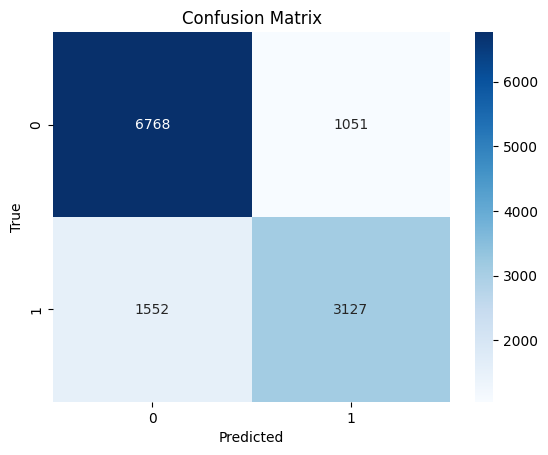

ROC-AUC Score: 0.8601


In [200]:
metrics_summary(y_test, y_pred_gb, y_pred_prob_gb)

In [201]:
best_lr = grid_lr.best_estimator_
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lr.coef_[0]
})

coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

In [202]:
best_gbc = grid_gb.best_estimator_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_gbc.feature_importances_
})
# Sort feature importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


In [203]:
print("Logistic Regression Coefficients:\n", coefficients)
print("\nGradient Boosting Feature Importances:\n", feature_importance)

Logistic Regression Coefficients:
                             Feature  Coefficient
0            trips_in_first_30_days    13.923598
1              avg_rating_of_driver     0.636417
8               city_King's Landing     0.568148
14         ultimate_black_user_True     0.469988
3                         surge_pct     0.384022
4                       weekday_pct     0.200977
25     last_trip_day_of_week_Sunday     0.146926
23     last_trip_day_of_week_Monday     0.143494
18        signup_day_of_week_Sunday     0.048930
12                     phone_iPhone     0.012113
21     signup_day_of_week_Wednesday     0.011564
16        signup_day_of_week_Monday     0.005259
17      signup_day_of_week_Saturday     0.003713
24   last_trip_day_of_week_Saturday    -0.022345
20       signup_day_of_week_Tuesday    -0.053351
27    last_trip_day_of_week_Tuesday    -0.082090
19      signup_day_of_week_Thursday    -0.084467
15        signup_day_of_week_Friday    -0.104516
22     last_trip_day_of_week_Frida

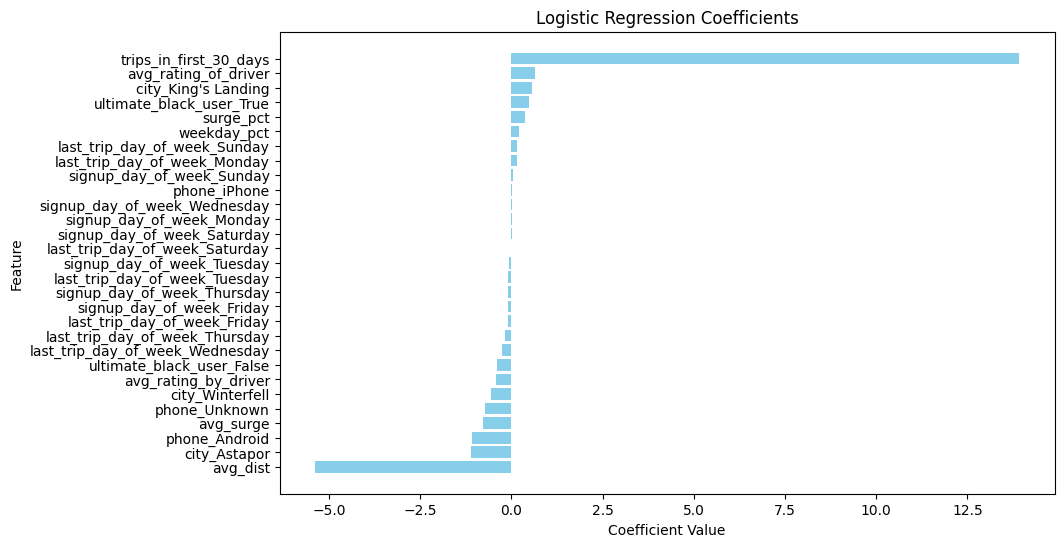

In [204]:
# Plotting the coefficients from Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Invert to have the highest coefficient at the top
plt.show()


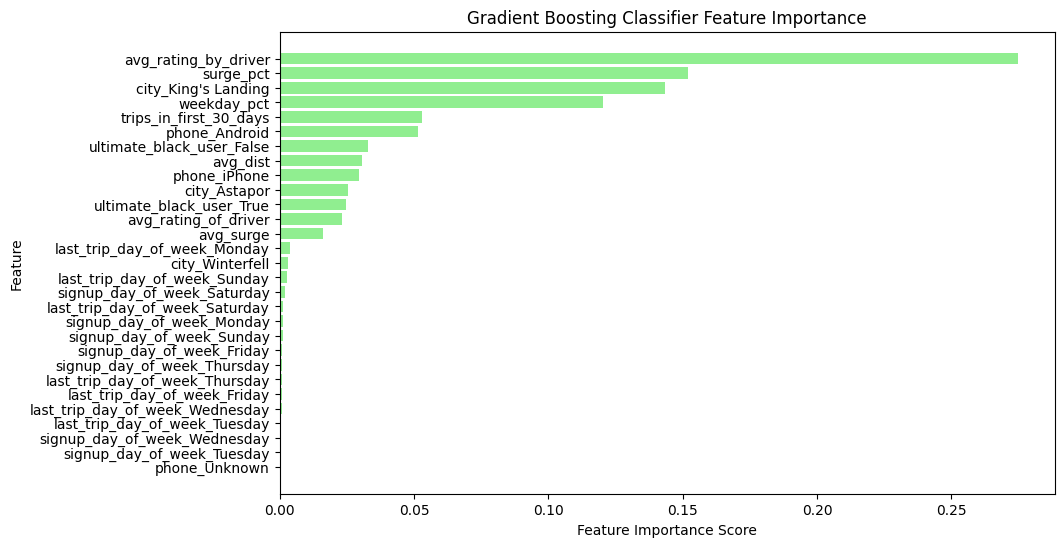

In [205]:
# Plotting the feature importance from Gradient Boosting Classifier
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='lightgreen')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Gradient Boosting Classifier Feature Importance')
plt.gca().invert_yaxis()  # Invert to have the highest importance at the top
plt.show()

The final Gradient Boosting Classifier achieved a ROC-AUC score of 0.86 and an accuracy of 0.79, while Logistic Regression achieved a ROC-AUC score of 0.77 and an accuracy of 0.72. Although the Gradient Boosting model better captures the complexities in the data, Logistic Regression offers greater interpretability through its coefficients, providing a clearer understanding of how each feature relates to retention. Analyzing both the coefficients from Logistic Regression and the feature importance from Gradient Boosting uncovered several key insights:

- Driver Ratings are Crucial: Both models highlight that avg_rating_by_driver is a top predictor, with a negative correlation to retention, indicating that lower ratings by drivers are associated with higher churn.

- Early Engagement is Key: trips_in_first_30_days is a prominent feature in both models, showing that higher early engagement strongly correlates with long-term retention.

- Impact of Surge Pricing: surge_pct is a strong predictor in the Gradient Boosting model, with a positive correlation to retention, suggesting that users who experience surge pricing more frequently may be more likely to stay engaged.

- Location-Specific Factors: Location-related features (city_King's Landing and city_Astapor) significantly impact retention, indicating that city-specific strategies may be needed to address regional behaviors.


### Recommendation for imporovement

- Improving early engagement, such as offering introductory promotions to encourage more trips in the first 30 days. 
- Investing in driver training to maintain high driver ratings could enhance the rider experience and reduce churn. 
- Providing discounts during peak times could help retain users who are sensitive to price fluctuations. 
- Finally, implementing location-specific retention strategies tailored to each city (e.g., King’s Landing and Astapor) could address region-specific preferences and behaviors.